##Transformer 구현
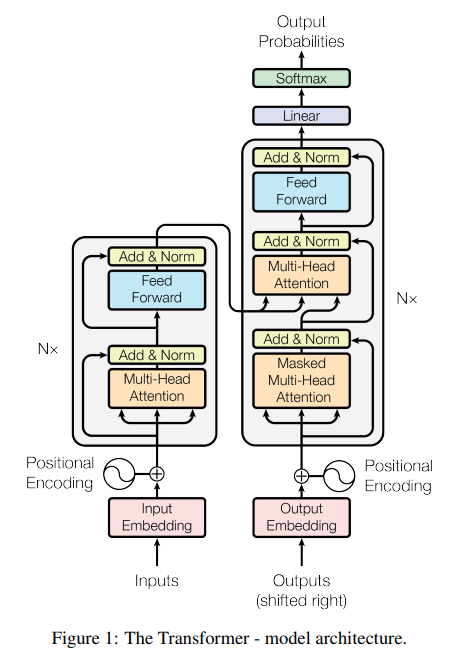

논문에서 제안한 트랜스포머 모델의 주요 파라메터는 다음과 같습니다.


> d_model - 트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기를 의미합니다. (default=512)

> num_encoder_layers - 트랜스포머 모델에서 인코더가 총 몇 층으로 구성되었는지를 의미합니다. (default=6)

> num_decoder_layers - 트랜스포머 모델에서 디코더가 총 몇 층으로 구성되었는지를 의미합니다. (default=6)

> nhead – 멀티헤드 어텐션 모델의 헤드 수, 어텐션을 사용할 때 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식에서 병렬의 수 (default=8)


> dim_feedforward – feedforward network model 의 차원, 피드 포워드 신경망의 은닉층의 크기(default=2048)





In [ ]:
# 필요한 패키지를 불러옵니다.
import torch
import torch.nn as nn
import torchtext
from torchtext import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder): #후에 encoder와 decoder클래스 구조를 입력
        self().__init__()

        self.encoder = encoder
        self.decoder = decoder

        def encode(self, x):
            result = self.encoder(x)
            return result

        def decode(self, c, z):    # 디코더는 context vec와 self-attention의 출력값을 입력값으로 받음
            result = self.decoder(c, z)
            return result


    def forward(self, x):
        context_vector = self.encode(x)
        y = self.decode(context_vector, z)

        return y

## Encoder를 구현해보겠습니다.

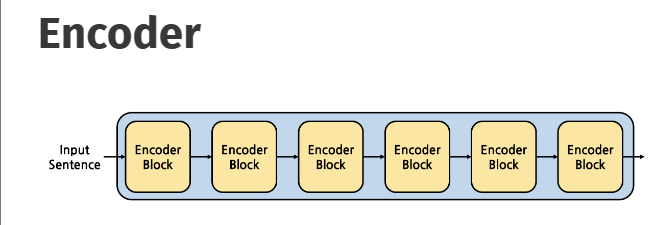

N = 6번 반복되는 Encoder Block구조를 설계해야 합니다.

> multi-head attention mechanism과 feed forward 과정을 함수로 구현합시다.
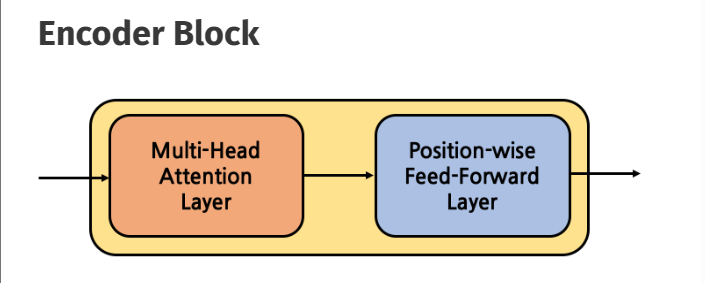

In [ ]:
# multi-head attention을 하기 위해, 우선 scaled-dot (self) attention을 또 먼저 정의해줘야겠지요?
def self_attention(query, key, value, mask = False):

    dim_q = query.shape[-1] #query와 key의 차원인 dk를 변수로 저장
    score = torch.matmul(query, key.transpose(-2, -1))    # 내적 결과, (batch_size, seq_length, seq_length) 차원을 갖는다. 중요
    score /= torch.sqrt(dim_q)          # scaling

    prob = F.softmax(score, dim = -1) # 텐서의 가장 마지막 dim에 대해 softmax계산시킴

    if mask == True:                    # masking 적용
        score = score.masked_fill(mask == 0, -1e-12)

    result = torch.matmul(prob, value)

    return result

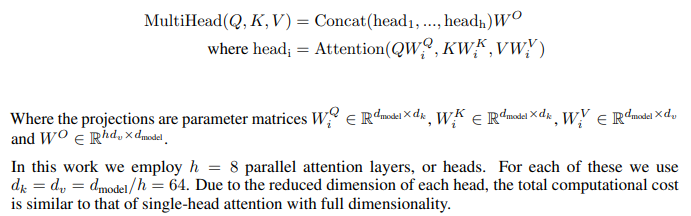

차원 생각을 해야해서 선형대수적인 지식이 있어야 이해가 수월하겠습니다.

In [ ]:
# 본격적으로 Multi-Head attention을 구현해봅시다.
# 이건 인코더에서만 사용하는, 마스킹도 필요없고 간단한 버전이라고 보면 됩니다.
class Multi_head_attention(nn.Module):
    def __init__(self, d_model = 512, n_head = 8):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.attention = self_attention()
        # 가중치 행렬(W)의 차원 = (d_model, d_model) = (512*512)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def split(self, tensor):        # i번째 단계로 split해주는 역할이라고 생각하면 됩니다.
        batch_size, seq_len, d_model= tensor.size()
        d_tensor = self.d_model // self.n_head  # 512/8이니까 64 겠죠

        splited_tensor = tensor.view(batch_size, self.n_head, seq_len, d_tensor)    # split시킬 차원으로 변경해줍니다

        return splited_tensor

    def concat(self, splited_tensor):       # concat해주는 역할입니다.
        batch_size, head_i, seq_len, d_tensor = splited_tensor.size()
        d_model = head_i*d_tensor           # 512가 나오겠죠

        tensor = splited_tensor.view(batch_size, seq_len, d_model) # 다시 합치기위해 (이건 forward에서 진행) 차원 변경

        return tensor

    def forward(self, q, k, v, mask = False):
        q, k, v = self.W_q(q), self.W_k(k), self.W_v(v) # Linear projection(product과 같은역할)해줍니다.
        # 결과는 각각 Q*W_q, K*W_k, V*W_v고, 각각의 차원은 (d_model, d_q)이런식으로 됩니다

        # 다음으로, 이것들을 병렬적으로 self-attention시켜주기 위해 i번째 (head)단계로 split해주겠습니다.
        q, k, v = self.split(q), self.split(k), self.split(v)

        # split된 Q*Wqi, K*Wki, V*Wvi를 self-attention해주도록 하겠습니다
        result = self.attention(q, k, v)

        # 마지막으로 이들을 concat시키고, W_o와 linear projection해줍니다.
        result = self.concat(result)
        result = self.W_o(result)

        return result


In [ ]:
# Add & Norm Layer에서는 residual connection으로 더해주고, layer normalization을 진행합니다.
# 근데 shortcut connection을 한번에 구현하기엔 애매하고 오히려 더 복잡해지니까, adding하는건 전체 아키텍처에서 구현
class Layer_Norm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-12):  # epsilon은 정규화할때 나눗셈에서 추가하는 역할
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model)) #nn.Parameter를 활용하면 학습가능한 파라미터로 등록됩니다.
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        result = (x - x.mean(-1, keepdims = True)) / (x.std(-1, keepdims = True) + self.epsilon)
        result = self.gamma*result + self.beta

        return result

In [ ]:
class FFN(nn.Module):           # Feed Forward wise Layer

    def __init__(self, Linear_transform1, Linear_transform2):
        super().__init__()

        self.fc1 = Linear_transform1    #선형변환(1)
        self.relu = nn.ReLU()
        self.fc2 = Linear_transform2    #선형변환(2)
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, x):

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.dropout(x)

        return x

# d_model = 512, feed_forward의 차원 = 2048
# 나중에 선형변환에서 nn.Linear 인자값으로 이용할 거니까 기억

In [ ]:
class Encoder_block(nn.Module):

    def __init__(self, d_model = 512, n_head = 8, drop_prob = 0.1):
        super().__init__()

        self.multi_head_attend = Multi_head_attention(d_model, n_head) # 디폴드 값(512, 8)으로 실행
        self.norm_1 = Layer_Norm(d_model = d_model)
        self.feed_forward = FFN(nn.Linear(512, 2048), nn.Linear(2048, 512))
        self.norm_2 = Layer_Norm(d_model = d_model)

    def forward(self, x):
        identity_mapping = x    # skip connection으로 더해주기 위해 미리 변수 빼서 저장함
        x = self.multi_head_attend(q = x, k = x, v = x, mask = None) #self-attention하는 것 확인 가능!
        x = self.norm_1(x)
        x += identity_mapping   # Add(shortcut-connection)
        x = nn.Dropout(p = self.drop_prob)

        identity_mapping_2 = x

        x = self.feed_forward(x)    #FFN
        x = self.norm_2(x)
        x += identity_mapping_2
        x = nn.Dropout(p = self.drop_prob)

        return x

In [ ]:
# 초기단계에 위치한 Positional Encoding을 구현해볼까요?
class Positional_Encoding(nn.Module):

    def __init__(self, len_max, d_model):
        super().__init__()

        self.encoding = torch.zeros(len_max, d_model)
        self.encoding.requires_grad = False # gradient계산할 필요 없기 때문에, 메모리 줄여주려고 False처리

        self.pos = torch.arange(0, self.len_max).float()

        self._2_i = torch.arange(0, self.len_max, step = 2).float()
        # 함수식에 들어가는 지수식(2^i)를 의미합니다

        self.encoding[:, 0::2] = torch.sin(self.pos /(10000**(self._2_i_i/self.d_model)))   # 문장에서 짝수번째 위치한 단어 encoding
        self.encoding[:, 1::2] = torch.cos(self.pos /(10000**(self._2_i/self.d_model)))      # 문장에서 홀수번째 위치한 단어 encoding

    def forward(self, x):

        batch_size, seq_len = x.size()
        return self.encoding[:seq_len, :]   # seq_len까지의 position 흠...(??)


In [ ]:
class Encoder(nn.Module):
    # Encoder에 입력으로 들어가는 문장은 Embedding을 거치고 Positional Encoding과 합쳐 들어가기 때문에, 이도 추가
    # 앞서 만든 Encoder block을 6번 반복해주어서 전체 Encoder를 완성시킵니다.

    def __init__(self, input_seq, d_model, vocab_size, len_max, feedforward_hodden, n_head = 8, N = 6):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings = len(input_seq.vocab '''입력데이터 여기서는 미정'''),
                                      embedding_dim = d_model, padding_idx=  1)

        self.positional_encoding = Positional_Encoding(len_max = len_max, d_model = d_model)

        self.encoder_stacks = nn.ModuleList([Encoder_block(d_model, n_head, drop_prob = 0.1)
                                             for _ in range(N)])    # N = 6번 Encoder_block반복

    def forward(self, x, mask_int):
        embedded_x = self.embedding(x)
        positional = self.positional_encoding(embedded_x)
        final_input = embedded_x + positional

        for layer in self.encoder_stacks:
            context_vector = layer(final_input)

            return context_vector


## 이제 Decoder를 구현해볼까요~
마찬가지로 6개의 디코더 블록이 이어진 구조이며, 하나의 디코더 블록을 설계하기 위해서는 masked multi-head attention 과 인코더에서의 context, 그리고 attention가중치 합을 입력값으로 받는 attention 두 구조를 거쳐서 FFFN을 거쳐서 설계하도록 합시다.

근데 encoder-decoder attention은 어차피 Decoder block 설계할 때, key와 value를 이전 encoder에서 뽑아오는걸로 수정하면 되니까 새로 만들 필요 없고, 마스킹도 option설정으로 할 수 있다고 합니다.

In [ ]:
class Decoder_block(nn.Module):

    def __init__(self, ffn_hidden, d_model = 512, n_head = 8, drop_porb = 0.1):
        super().__init__()

        self.multi_head_atention = Multi_head_attention(d_model, n_head)
        self.norm_1 = Layer_Norm(d_model = d_model)

        self.encoder_decoder_attention = Multi_head_attention(d_model, n_head)
        self.norm_2 = Layer_Norm(d_model = d_model)

        self.feed_forward = FFN(nn.Linear(512, ffn_hidden), nn.Linear(ffn_hidden, 512))
        self.norm_3 = Layer_Norm(d_model = d_model)


    def forward(self, x, encoded):
        identity_mapping = x
        x = self.multi_head_attention(q = x, k = x, v = x)
        # 여기서는 마스킹 처리 과정이 후에 전체 아키텍처 구성할 때 추가되어야함
        x = self.norm_1(x)
        x += identity_mapping
        x = nn.Dropout(p = self.drop_prob)

        identity_mapping_2 = x
        x = self.encoder_decoder_attention(q = x, k = encoded, v = encoded)
        # encoder구조와 다른 점(key와 value에 encoder출력값이 들어가는 것)입니다.
        x = self.norm_2(x)
        x += identity_mapping_2
        x = nn.Dropout(p = self.drop_prob)

        identity_mapping_3 = x
        x = self.feed_forward(x)
        x = self.norm_3(x)
        x += identity_mapping_3
        x = nn.Dropout(p = self.drop_prob)

        return x

In [ ]:
class Decoder(nn.Module):

    def __init__(self, decoder_seq, d_model, vocab_size, len_max, feedforward_hodden, n_head = 8, N = 6):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings = len(decoder_seq.vocab),
                                      embedding_dim = d_model, padding_idx = 1)
        self.position_encoding = Positional_Encoding(len_max = len_max, d_model = d_model)
        self.layers = nn.ModuleList([Decoder_block(ffn_hidden = 2048, d_model = 512, n_head = 8, drop_prob = 0.1)]
                                    for _ in range(N = 6))

    def forward(self, x, encoded):
        embedded_x = self.embedding(x)
        positional = self.positional_encoding(x)

        final_input = embedded_x + positional

        for layer in self.layers:
            out = layer(final_input, encoded)

        return out

### 마침내 최종 Transforemr를 구현할 수 있습니다.

In [ ]:
class Transformer(nn.Module):

    def __init__(self, pad_idx, )